In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap

# Alltoall 

In [ ]:
df_multinode = pd.read_csv("../data/data-multi-defand100cflag.csv",delimiter = ",")
df_multinode['benchmark_type'].unique()
df_gather = df_multinode[df_multinode["benchmark_type"]=="Gather"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]
df_gather.columns.tolist()

/tmp/ipykernel_4897/23514614.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_gather = df_multinode[df_multinode["benchmark_type"]=="Gather"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]
/tmp/ipykernel_4897/23514614.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_gather = df_multinode[df_multinode["benchmark_type"]=="Gather"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]


['benchmark_type',
 'proc_num',
 'msg_size_bytes',
 'repetitions',
 't_min_usec',
 't_max_usec',
 't_avg_usec',
 'mpi_datatype',
 'mpi_red_datatype',
 'mpi_red_op',
 'creation_time',
 'n_nodes',
 'off_cache_flag']

: 

/tmp/ipykernel_4897/866829124.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


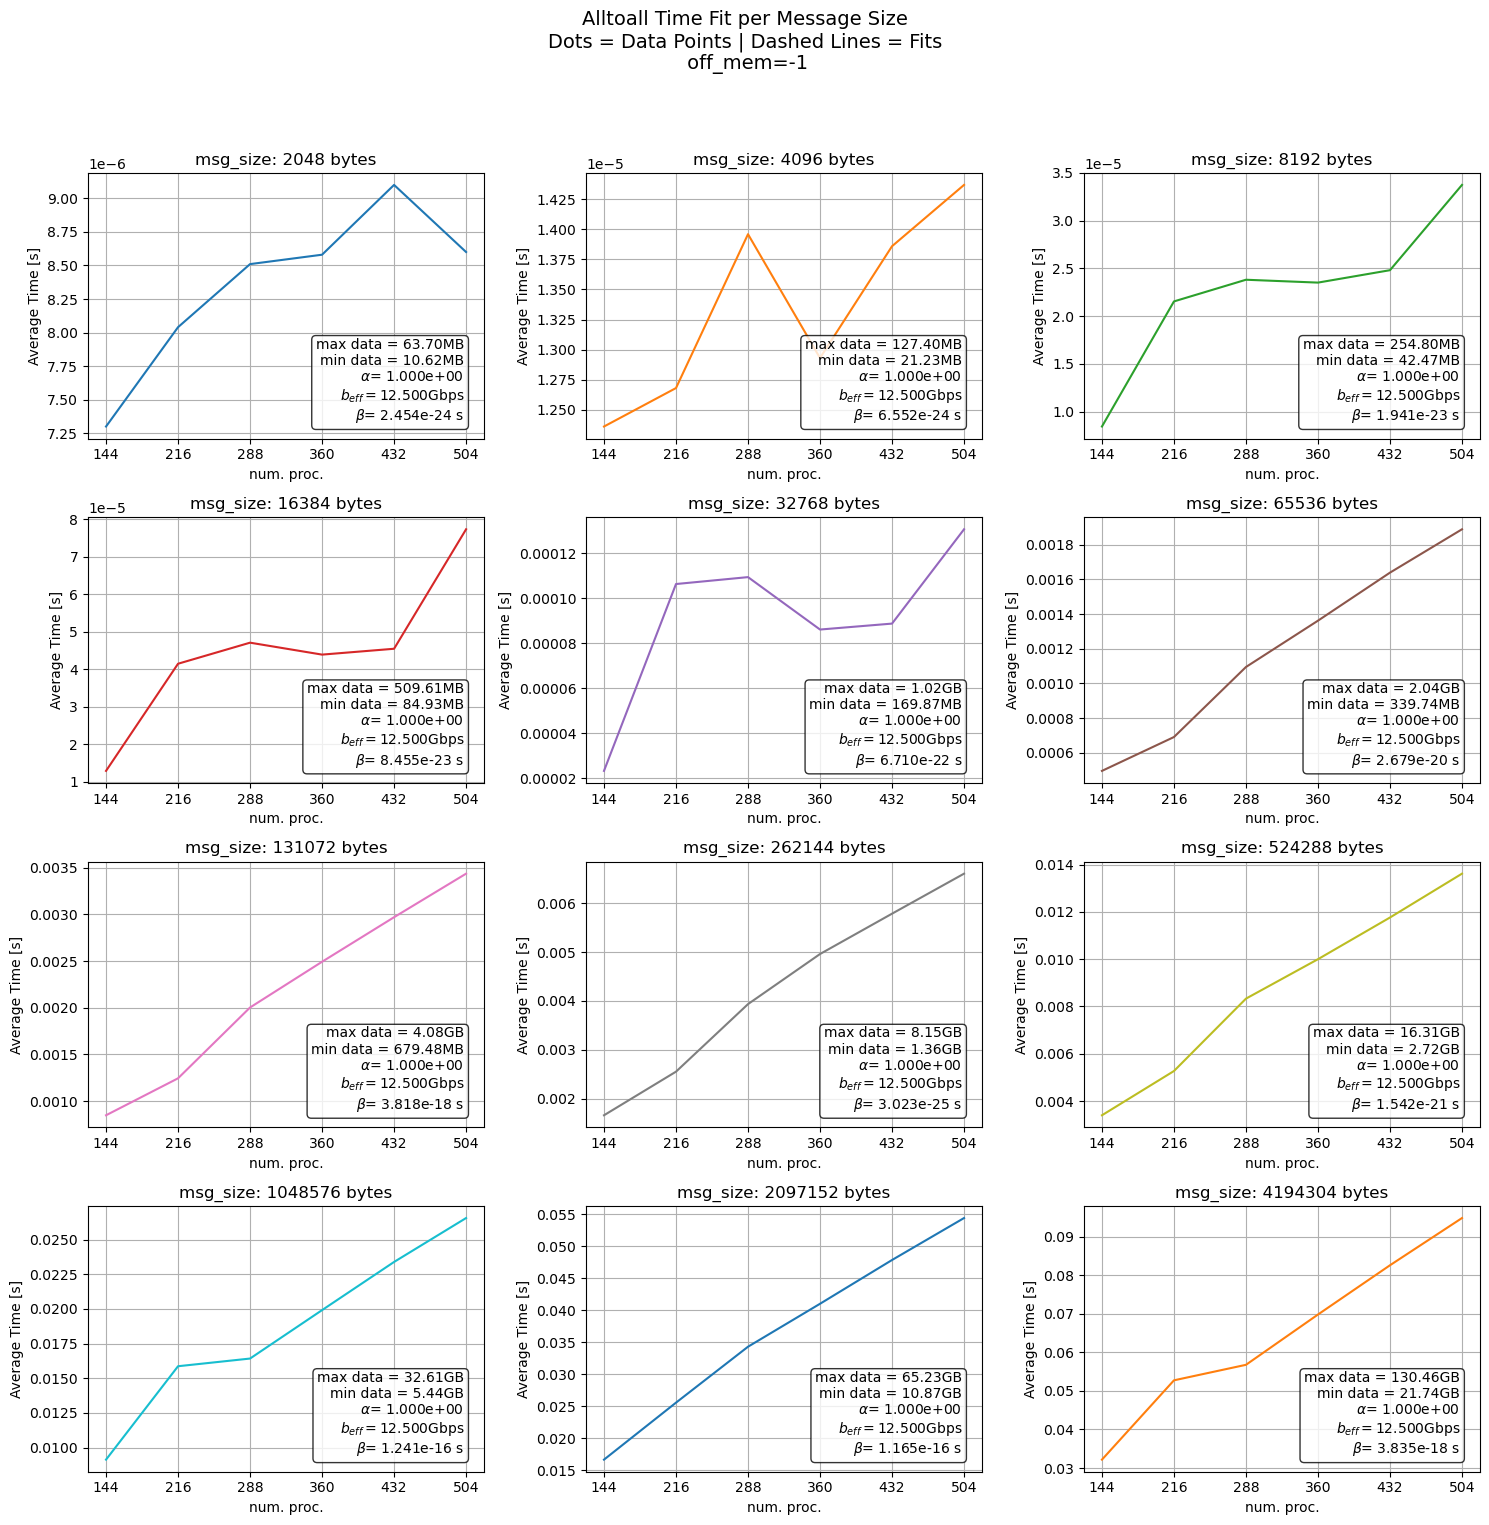

    msg_size_bytes  alpha          beta  inv_alpha
0             2048    1.0  2.453824e-24        1.0
1             4096    1.0  6.552190e-24        1.0
2             8192    1.0  1.941168e-23        1.0
3            16384    1.0  8.454933e-23        1.0
4            32768    1.0  6.710026e-22        1.0
5            65536    1.0  2.678877e-20        1.0
6           131072    1.0  3.818473e-18        1.0
7           262144    1.0  3.023451e-25        1.0
8           524288    1.0  1.541516e-21        1.0
9          1048576    1.0  1.240501e-16        1.0
10         2097152    1.0  1.165495e-16        1.0
11         4194304    1.0  3.834525e-18        1.0


: 

In [ ]:
def model(proc_num, alpha, beta, msg_size):
    return (alpha * msg_size * (proc_num - 72) * 72) / (12.5 * 1e3) + 1e6*beta

results = []
msg_sizes = sorted(df_gather['msg_size_bytes'].unique())
n_rows = int(np.ceil(len(msg_sizes) / 3))
n_cols = min(len(msg_sizes), 3)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
cmap = get_cmap('tab10')

for idx, (msg_size, group) in enumerate(df_gather.groupby('msg_size_bytes')):
    x = group['proc_num'].values.copy()
    y = group['t_avg_usec'].values.copy()
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    fit_func = lambda proc_num, alpha, beta: model(proc_num, alpha, beta, msg_size)
    popt, _ = curve_fit(fit_func, x, y, bounds=([1, 0], [np.inf, np.inf]))
    alpha, beta = popt
    results.append({'msg_size_bytes': msg_size, 'alpha': alpha, 'beta': beta})

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fit_func(x_fit, alpha, beta)
    y_speed = model(x_fit,1,0,msg_size)
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    color = cmap(idx % 10)
    # ax.scatter(x, y/1e6, label='Data', color=color)
    ax.plot(x, y/1e6, label='Data', color=color)
    # ax.plot(x_fit, y_fit/1e6, linestyle='--', color=color, alpha=0.5, label='Fit')
    # ax.plot(x_fit, y_speed/1e6, linestyle='--', color='red', alpha=0.1, label='Fit')
    ax.set_title(f'msg_size: {msg_size} bytes')
    ax.set_xlabel('num. proc.')
    ax.set_ylabel('Average Time [s]')
    ax.set_xticks(x)
    ax.grid(True)
    max_data =(x[-1]-72)*72*msg_size
    min_data =(x[0]-72)*72*msg_size

    textstr = ""
    # if(max_data > 1e9):
    #     textstr+=f"max data = {max_data/1e9:0.2f}GB\n" 
    # else:
    #     textstr+=f"max data = {max_data/1e6:0.2f}MB\n" 

    # if(min_data > 1e9):
    #     textstr+=f"min data = {min_data/1e9:0.2f}GB\n" 
    # else:
    #     textstr+=f"min data = {min_data/1e6:0.2f}MB\n" 
    # textstr += r"$\alpha$" +f"= {alpha:.3e}\n"+r"$b_{eff}=$"+f"{12.5/alpha:0.3f}Gbps\n"+\
    #            r"$\beta$"+f"= {beta:.3e} s"
    # ax.text(0.95, 0.05, textstr, transform=ax.transAxes,
    #         fontsize=10, verticalalignment='bottom',
    #         horizontalalignment='right',
    #         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Alltoall Time Fit per Message Size\nDots = Data Points | Dashed Lines = Fits\n off_mem=-1', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("plots/alltoall_analysis.png",dpi=300)
plt.show()

fit_results = pd.DataFrame(results)
fit_results['inv_alpha'] = 1 / fit_results['alpha']
print(fit_results)


In [ ]:
df_gather[df_gather['msg_size_bytes']==1048576]

benchmark_type  proc_num  msg_size_bytes  repetitions  t_min_usec  \
470          Gather       360         1048576           40      233.94   
608          Gather       432         1048576           40      232.50   
1096         Gather       504         1048576           40      229.70   
1349         Gather       144         1048576           40      235.39   
2228         Gather       288         1048576           40      237.25   
3067         Gather       216         1048576           40      223.96   

      t_max_usec  t_avg_usec mpi_datatype mpi_red_datatype mpi_red_op  \
470     36747.90    19914.01     MPI_BYTE        MPI_FLOAT    MPI_SUM   
608     42935.80    23389.38     MPI_BYTE        MPI_FLOAT    MPI_SUM   
1096    48937.39    26558.04     MPI_BYTE        MPI_FLOAT    MPI_SUM   
1349    17983.16     9125.46     MPI_BYTE        MPI_FLOAT    MPI_SUM   
2228    31719.94    16419.63     MPI_BYTE        MPI_FLOAT    MPI_SUM   
3067    24058.05    15865.52     MPI_BYTE        MPI_FLOAT    MPI_SUM   

          creation_time  n_nodes  off_cache_flag  
470   25_07_26_05-44-37        5              -1  
608   25_07_26_05-44-37        6              -1  
1096  25_07_26_05-44-37        7              -1  
1349  25_07_26_05-44-37        2              -1  
2228  25_07_26_05-44-37        4              -1  
3067  25_07_26_05-44-37        3              -1

: 